BUAI 435 Assignment 1 - Churn Prediction  
Name: Ruihuang Yang  
NetID: rxy216  
Date: 09/14/2025  

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import statsmodels.api as sm

# Set up beautiful plotting style
plt.style.use('default')
sns.set_palette("husl")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

### Q1 - Steps 1 & 2: Preprocessing & Variable Setup

#### Load the CSV data

In [2]:
# Load the dataset
df = pd.read_csv('data/Telco-Customer-Churn.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset shape: (7043, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


#### Preprocessing: TotalCharges and Churn conversion

In [3]:
# Coerce TotalCharges to numeric and impute missing values with mean
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
mean_total_charges = df['TotalCharges'].mean()
print(f"Missing values in TotalCharges before imputation: {df['TotalCharges'].isna().sum()}")
df['TotalCharges'] = df['TotalCharges'].fillna(mean_total_charges)
print(f"TotalCharges mean used for imputation: {mean_total_charges:.2f}")
print(f"Missing values in TotalCharges after imputation: {df['TotalCharges'].isna().sum()}")

# Convert Churn to 0/1 (Yes=1, No=0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print(f"Churn value counts:\n{df['Churn'].value_counts()}")

Missing values in TotalCharges before imputation: 11
TotalCharges mean used for imputation: 2283.30
Missing values in TotalCharges after imputation: 0
Churn value counts:
Churn
0    5174
1    1869
Name: count, dtype: int64


#### Create Manual Dummy Variables

In [4]:
# Manually create four dummies (do NOT one-hot encode these)
df['gender_Female'] = (df['gender'] == 'Female').astype(int)
df['PhoneService_Yes'] = (df['PhoneService'] == 'Yes').astype(int)
df['InternetService_Fiber optic'] = (df['InternetService'] == 'Fiber optic').astype(int)
df['Contract_Two year'] = (df['Contract'] == 'Two year').astype(int)

print("Manual dummy variables created:")
print(f"gender_Female: {df['gender_Female'].value_counts().to_dict()}")
print(f"PhoneService_Yes: {df['PhoneService_Yes'].value_counts().to_dict()}")
print(f"InternetService_Fiber optic: {df['InternetService_Fiber optic'].value_counts().to_dict()}")
print(f"Contract_Two year: {df['Contract_Two year'].value_counts().to_dict()}")

Manual dummy variables created:
gender_Female: {0: 3555, 1: 3488}
PhoneService_Yes: {1: 6361, 0: 682}
InternetService_Fiber optic: {0: 3947, 1: 3096}
Contract_Two year: {0: 5348, 1: 1695}


#### Data Overview - Info and Head

In [5]:
# Show df.info() and df.head() for sanity check
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customerID                   7043 non-null   object 
 1   gender                       7043 non-null   object 
 2   SeniorCitizen                7043 non-null   int64  
 3   Partner                      7043 non-null   object 
 4   Dependents                   7043 non-null   object 
 5   tenure                       7043 non-null   int64  
 6   PhoneService                 7043 non-null   object 
 7   MultipleLines                7043 non-null   object 
 8   InternetService              7043 non-null   object 
 9   OnlineSecurity               7043 non-null   object 
 10  OnlineBackup                 7043 non-null   object 
 11  DeviceProtection             7043 non-null   object 
 12  TechSupport                  7043 non-null   object 
 13  Stre

In [6]:
print("\nFirst 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_Female,PhoneService_Yes,InternetService_Fiber optic,Contract_Two year
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,0,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,One year,No,Mailed check,56.95,1889.50,0,0,1,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,1,0,1,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,One year,No,Bank transfer (automatic),42.30,1840.75,0,0,0,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,1,1,1,1,0


### Q2 - Step 3: EDA (Exploratory Data Analysis)

#### Setup: Create graphs folder for saving plots

In [7]:
# Create graphs folder if it doesn't exist
os.makedirs('graphs', exist_ok=True)
print("Graphs folder created/verified")

Graphs folder created/verified


#### Distribution Analysis for Numeric Variables

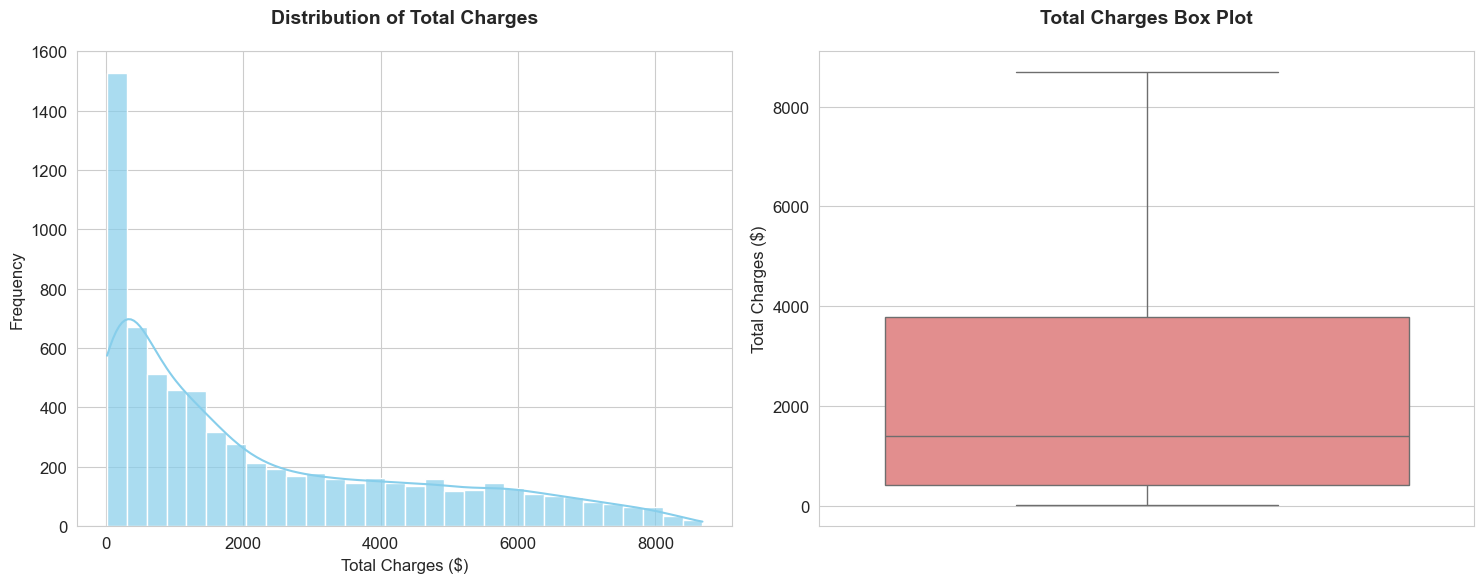

=== TOTAL CHARGES - BASIC STATISTICS ===
Mean: $2283.30
Median: $1400.55
Standard Deviation: $2265.00
Minimum: $18.80
Maximum: $8684.80
25th Percentile: $402.23
75th Percentile: $3786.60


In [8]:
# Analyze distribution of TotalCharges (a key numeric variable)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Distribution plot with histogram and KDE
sns.histplot(data=df, x='TotalCharges', bins=30, kde=True, ax=ax1, color='skyblue', alpha=0.7)
ax1.set_title('Distribution of Total Charges', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Total Charges ($)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)

# Box plot to show outliers and quartiles
sns.boxplot(data=df, y='TotalCharges', ax=ax2, color='lightcoral')
ax2.set_title('Total Charges Box Plot', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('Total Charges ($)', fontsize=12)

plt.tight_layout()
plt.savefig('graphs/totalcharges_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Basic statistics for TotalCharges
print("=== TOTAL CHARGES - BASIC STATISTICS ===")
print(f"Mean: ${df['TotalCharges'].mean():.2f}")
print(f"Median: ${df['TotalCharges'].median():.2f}")
print(f"Standard Deviation: ${df['TotalCharges'].std():.2f}")
print(f"Minimum: ${df['TotalCharges'].min():.2f}")
print(f"Maximum: ${df['TotalCharges'].max():.2f}")
print(f"25th Percentile: ${df['TotalCharges'].quantile(0.25):.2f}")
print(f"75th Percentile: ${df['TotalCharges'].quantile(0.75):.2f}")

#### Monthly Charges Distribution

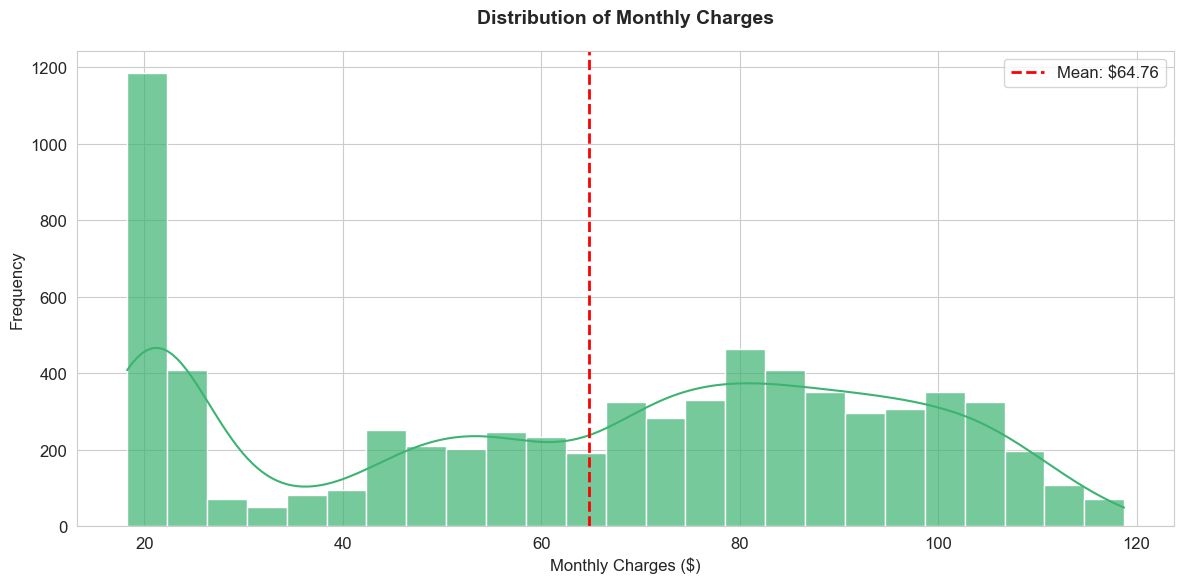

=== MONTHLY CHARGES - BASIC STATISTICS ===
Mean: $64.76
Median: $70.35
Standard Deviation: $30.09
Range: $18.25 - $118.75


In [9]:
# Also analyze MonthlyCharges distribution
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=df, x='MonthlyCharges', bins=25, kde=True, ax=ax, color='mediumseagreen', alpha=0.7)
ax.set_title('Distribution of Monthly Charges', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Monthly Charges ($)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Add mean line
mean_monthly = df['MonthlyCharges'].mean()
ax.axvline(mean_monthly, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_monthly:.2f}')
ax.legend()

plt.tight_layout()
plt.savefig('graphs/monthlycharges_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("=== MONTHLY CHARGES - BASIC STATISTICS ===")
print(f"Mean: ${df['MonthlyCharges'].mean():.2f}")
print(f"Median: ${df['MonthlyCharges'].median():.2f}")
print(f"Standard Deviation: ${df['MonthlyCharges'].std():.2f}")
print(f"Range: ${df['MonthlyCharges'].min():.2f} - ${df['MonthlyCharges'].max():.2f}")

#### Churn Rate Analysis

=== OVERALL CHURN RATE ===
Overall Churn Rate: 26.5% (1,869 out of 7,043 customers)


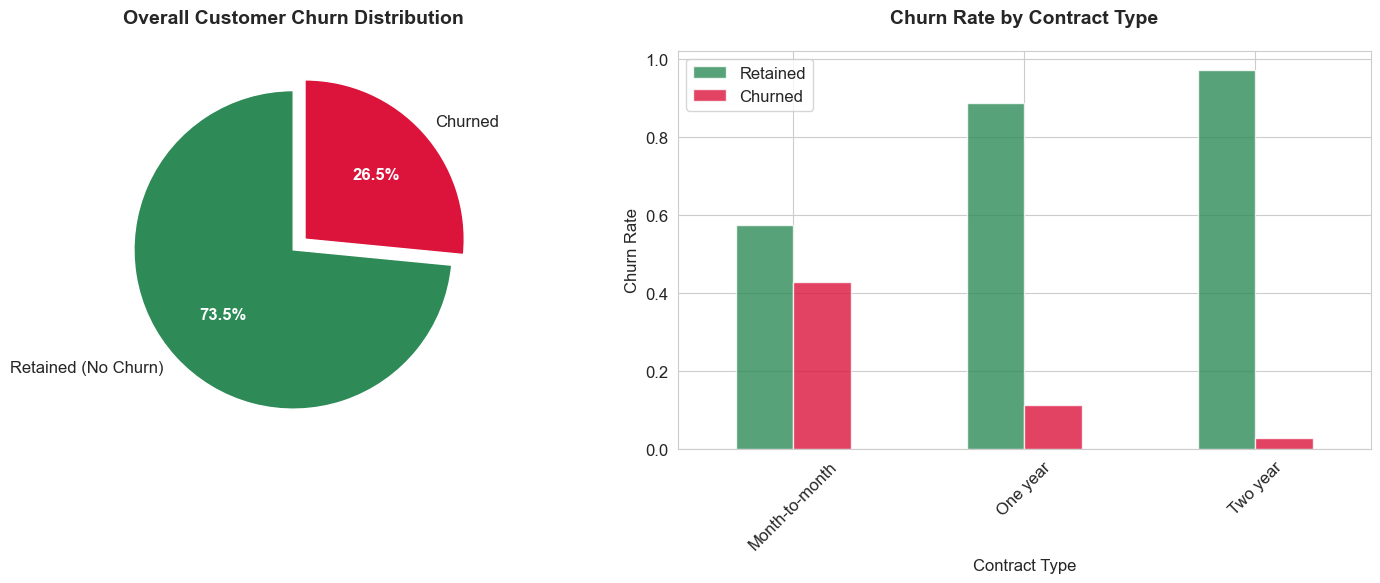

In [10]:
# Overall churn rate
overall_churn_rate = df['Churn'].mean()
print("=== OVERALL CHURN RATE ===")
print(f"Overall Churn Rate: {overall_churn_rate:.1%} ({df['Churn'].sum():,} out of {len(df):,} customers)")

# Create beautiful churn rate visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Overall churn pie chart
churn_counts = df['Churn'].value_counts()
labels = ['Retained (No Churn)', 'Churned']
colors = ['#2E8B57', '#DC143C']
wedges, texts, autotexts = ax1.pie(churn_counts.values, labels=labels, autopct='%1.1f%%', 
                                   colors=colors, startangle=90, explode=(0, 0.1))
ax1.set_title('Overall Customer Churn Distribution', fontsize=14, fontweight='bold', pad=20)

# Beautify the text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

# Churn rate by Contract type
contract_churn = pd.crosstab(df['Contract'], df['Churn'], normalize='index')
contract_churn.plot(kind='bar', ax=ax2, color=['#2E8B57', '#DC143C'], alpha=0.8)
ax2.set_title('Churn Rate by Contract Type', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Contract Type', fontsize=12)
ax2.set_ylabel('Churn Rate', fontsize=12)
ax2.legend(['Retained', 'Churned'], loc='upper left')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('graphs/churn_analysis_overview.png', dpi=300, bbox_inches='tight')
plt.show()

#### Detailed Churn Analysis by Contract Type

=== CHURN RATE BY CONTRACT TYPE ===
Raw counts:
Churn              0     1   All
Contract                        
Month-to-month  2220  1655  3875
One year        1307   166  1473
Two year        1647    48  1695
All             5174  1869  7043

Percentages:
Churn              0     1
Contract                  
Month-to-month  57.3  42.7
One year        88.7  11.3
Two year        97.2   2.8


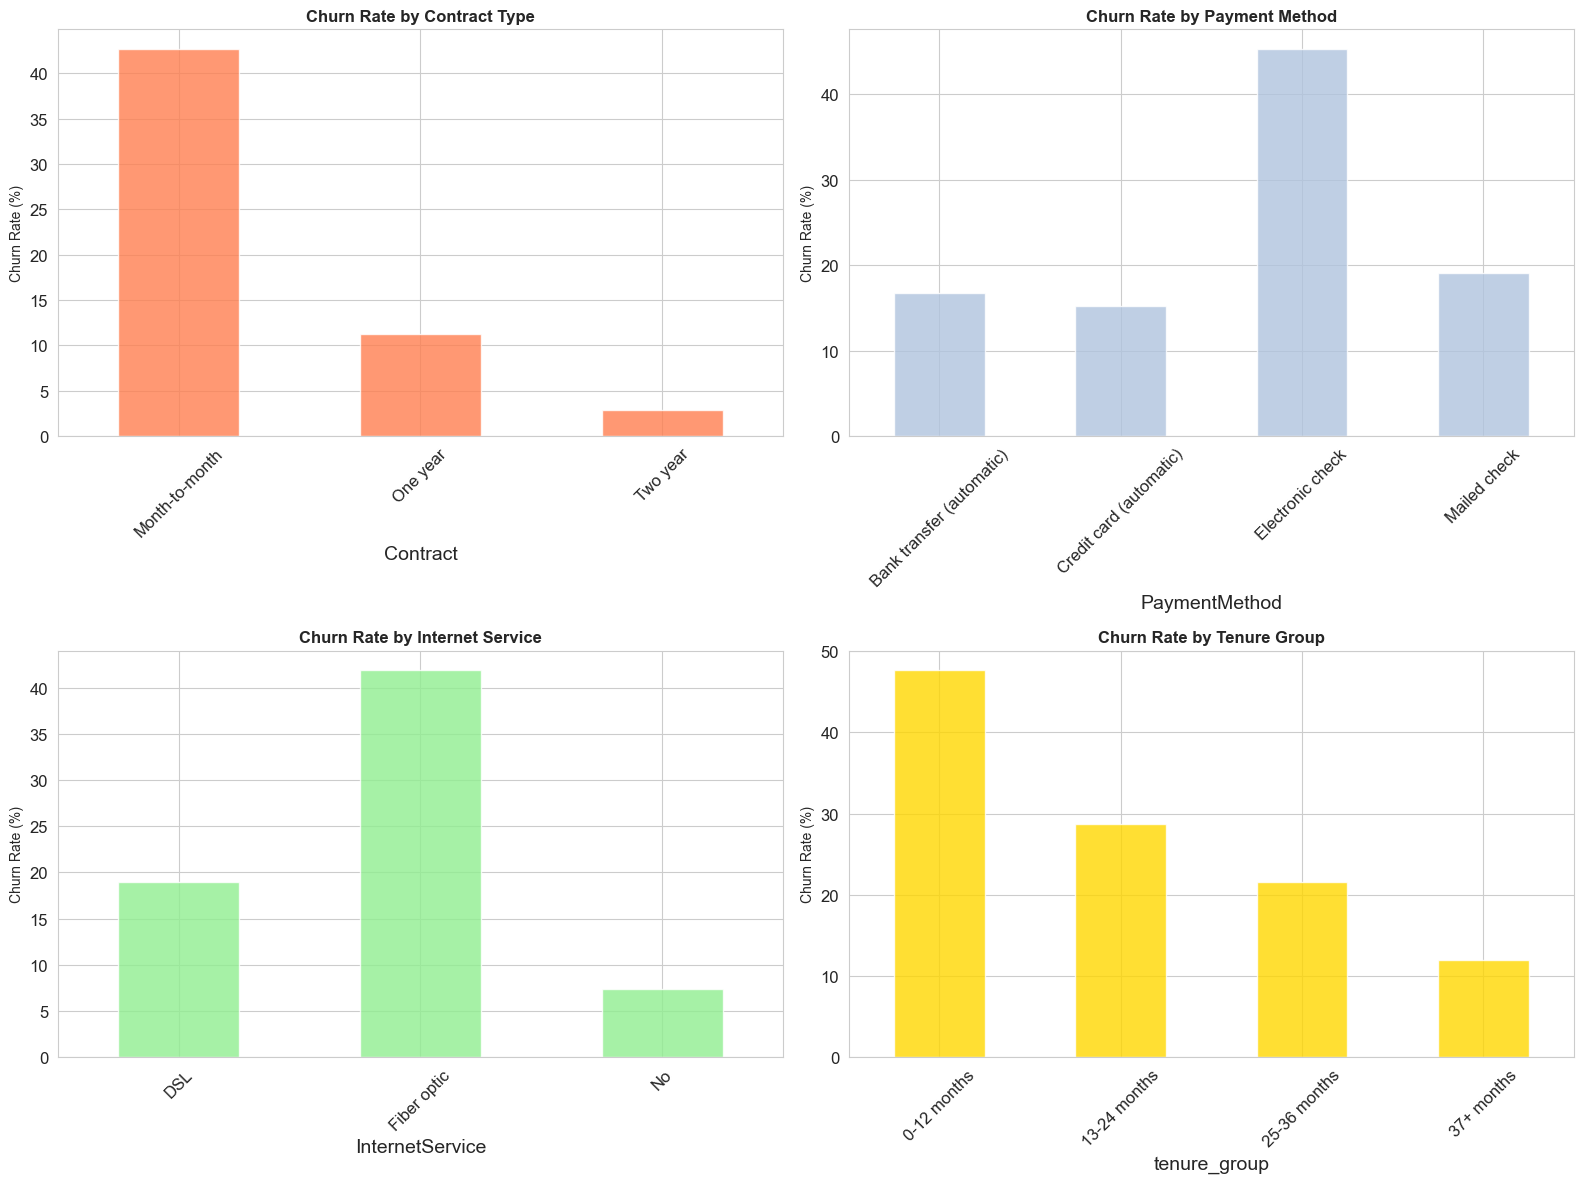

In [11]:
# Create crosstab for Contract vs Churn
contract_crosstab = pd.crosstab(df['Contract'], df['Churn'], margins=True)
contract_churn_pct = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100

print("=== CHURN RATE BY CONTRACT TYPE ===")
print("Raw counts:")
print(contract_crosstab)
print("\nPercentages:")
print(contract_churn_pct.round(1))

# Beautiful bar chart for churn rates by different categories
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Churn by Contract Type
contract_churn_pct[1].plot(kind='bar', ax=ax1, color='coral', alpha=0.8)
ax1.set_title('Churn Rate by Contract Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Churn Rate (%)', fontsize=10)
ax1.tick_params(axis='x', rotation=45)

# 2. Churn by Payment Method
payment_churn = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index')[1] * 100
payment_churn.plot(kind='bar', ax=ax2, color='lightsteelblue', alpha=0.8)
ax2.set_title('Churn Rate by Payment Method', fontsize=12, fontweight='bold')
ax2.set_ylabel('Churn Rate (%)', fontsize=10)
ax2.tick_params(axis='x', rotation=45)

# 3. Churn by Internet Service
internet_churn = pd.crosstab(df['InternetService'], df['Churn'], normalize='index')[1] * 100
internet_churn.plot(kind='bar', ax=ax3, color='lightgreen', alpha=0.8)
ax3.set_title('Churn Rate by Internet Service', fontsize=12, fontweight='bold')
ax3.set_ylabel('Churn Rate (%)', fontsize=10)
ax3.tick_params(axis='x', rotation=45)

# 4. Churn by Tenure groups
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 72], labels=['0-12 months', '13-24 months', '25-36 months', '37+ months'])
tenure_churn = pd.crosstab(df['tenure_group'], df['Churn'], normalize='index')[1] * 100
tenure_churn.plot(kind='bar', ax=ax4, color='gold', alpha=0.8)
ax4.set_title('Churn Rate by Tenure Group', fontsize=12, fontweight='bold')
ax4.set_ylabel('Churn Rate (%)', fontsize=10)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('graphs/churn_by_categories.png', dpi=300, bbox_inches='tight')
plt.show()

#### EDA Insights and Observations

**Key Observations from EDA:**

• **Customer Revenue Distribution Insights**: Total charges exhibit a highly right-skewed distribution (mean $2,283 vs median $1,401), indicating that most customers generate lower lifetime revenue while a minority are high-value customers. Monthly charges are more balanced (mean $64.76 vs median $70.35) with substantial variation ($18-$119 range), suggesting diverse service tier adoption across the customer base.

• **Contract Commitment as Primary Churn Driver**: The data reveals a dramatic churn gradient by contract type - month-to-month customers have a 42.7% churn rate (15x higher risk), one-year contracts show 11.3% churn, while two-year contracts demonstrate exceptional retention at just 2.8% churn. This 40-point difference underscores contract commitment as the strongest predictor of customer retention.

• **Customer Lifecycle and Service Risk Factors**: Analysis reveals that newer customers (0-12 months tenure) face the highest churn risk, while fiber optic internet subscribers and electronic check payment users show elevated churn rates. The overall company churn rate of 26.5% (1,869 of 7,043 customers) suggests significant revenue at risk, particularly concentrated in the month-to-month segment which represents 55% of the customer base.

### Q3 - Step 4: Feature Engineering & Modeling

#### Feature Selection

**Selected Features (≥8 features):**
- **Numeric Features**: `tenure`, `MonthlyCharges`, `TotalCharges`
- **Manual Dummy Variables**: `gender_Female`, `PhoneService_Yes`, `InternetService_Fiber optic`, `Contract_Two year`
- **High-Impact Predictors**: `PaymentMethod_Electronic check`, `Contract_Month-to-month` (based on EDA insights)
- **Additional Features**: `SeniorCitizen`, `Dependents_Yes`, `PaperlessBilling_Yes`, `OnlineSecurity_Yes`, `TechSupport_Yes`

#### Feature Engineering and Data Preparation

In [12]:
# Create additional dummy variables for key features
df['Dependents_Yes'] = (df['Dependents'] == 'Yes').astype(int)
df['PaperlessBilling_Yes'] = (df['PaperlessBilling'] == 'Yes').astype(int)
df['OnlineSecurity_Yes'] = (df['OnlineSecurity'] == 'Yes').astype(int)
df['TechSupport_Yes'] = (df['TechSupport'] == 'Yes').astype(int)

# Create high-impact predictor dummies based on EDA insights
df['PaymentMethod_Electronic check'] = (df['PaymentMethod'] == 'Electronic check').astype(int)
df['Contract_Month-to-month'] = (df['Contract'] == 'Month-to-month').astype(int)

print("High-impact predictor dummies created:")
print(f"PaymentMethod_Electronic check: {df['PaymentMethod_Electronic check'].value_counts().to_dict()}")
print(f"Contract_Month-to-month: {df['Contract_Month-to-month'].value_counts().to_dict()}")

# Build feature matrix X with ≥8 features (including the 4 manual dummies from Q1)
feature_columns = [
    # Numeric features
    'tenure', 'MonthlyCharges', 'TotalCharges',
    # Manual dummies from Q1
    'gender_Female', 'PhoneService_Yes', 'InternetService_Fiber optic', 'Contract_Two year',
    # High-impact predictors based on EDA
    'PaymentMethod_Electronic check', 'Contract_Month-to-month',
    # Additional features
    'SeniorCitizen', 'Dependents_Yes', 'PaperlessBilling_Yes', 'OnlineSecurity_Yes', 'TechSupport_Yes'
]

X = df[feature_columns]
y = df['Churn']

print(f"Feature matrix shape: {X.shape}")
print(f"Features selected: {len(feature_columns)}")
print(f"Feature names: {feature_columns}")
print("\nFirst few rows of X:")
print(X.head())

High-impact predictor dummies created:
PaymentMethod_Electronic check: {0: 4678, 1: 2365}
Contract_Month-to-month: {1: 3875, 0: 3168}
Feature matrix shape: (7043, 14)
Features selected: 14
Feature names: ['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Female', 'PhoneService_Yes', 'InternetService_Fiber optic', 'Contract_Two year', 'PaymentMethod_Electronic check', 'Contract_Month-to-month', 'SeniorCitizen', 'Dependents_Yes', 'PaperlessBilling_Yes', 'OnlineSecurity_Yes', 'TechSupport_Yes']

First few rows of X:
   tenure  MonthlyCharges  TotalCharges  gender_Female  PhoneService_Yes  \
0       1           29.85         29.85              1                 0   
1      34           56.95       1889.50              0                 1   
2       2           53.85        108.15              0                 1   
3      45           42.30       1840.75              0                 0   
4       2           70.70        151.65              1                 1   

   InternetService_Fib

#### Train-Test Split

In [13]:
# Split data into training and test sets with reproducible random state
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training churn rate: {y_train.mean():.3f}")
print(f"Test churn rate: {y_test.mean():.3f}")

Training set size: 5634 samples
Test set size: 1409 samples
Training churn rate: 0.265
Test churn rate: 0.265


#### Feature Scaling with StandardScaler

In [14]:
# Fit StandardScaler on training set only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Apply same fitted scaler to test set

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

print("Scaling completed - fitted on training set only")
print(f"Training set mean (should be ~0): {X_train_scaled.mean().mean():.6f}")
print(f"Training set std (should be ~1): {X_train_scaled.std().mean():.6f}")
print(f"Test set mean (will differ from 0): {X_test_scaled.mean().mean():.6f}")
print(f"Test set std (will differ from 1): {X_test_scaled.std().mean():.6f}")

print("\nScaled training data preview:")
print(X_train_scaled.head())

Scaling completed - fitted on training set only
Training set mean (should be ~0): -0.000000
Training set std (should be ~1): 1.000089
Test set mean (will differ from 0): -0.008837
Test set std (will differ from 1): 0.991188

Scaled training data preview:
        tenure  MonthlyCharges  TotalCharges  gender_Female  PhoneService_Yes  \
3738  0.102371       -0.521976     -0.263871      -0.994336         -3.013090   
3151 -0.711743        0.337478     -0.505423      -0.994336          0.331885   
4860 -0.793155       -0.809013     -0.751850      -0.994336         -3.013090   
3867 -0.263980        0.284384     -0.174271       1.005696          0.331885   
3810 -1.281624       -0.676279     -0.991514      -0.994336          0.331885   

      InternetService_Fiber optic  Contract_Two year  \
3738                    -0.887696          -0.563822   
3151                     1.126512          -0.563822   
4860                    -0.887696           1.773611   
3867                    -0.887696 

#### Logistic Regression Model with Statsmodels

In [15]:
# Add intercept term for statsmodels GLM
X_train_with_intercept = sm.add_constant(X_train_scaled)
X_test_with_intercept = sm.add_constant(X_test_scaled)

# Fit logistic regression model using GLM with Binomial family
logistic_model = sm.GLM(y_train, X_train_with_intercept, family=sm.families.Binomial()).fit()

# Display model summary
print("=== LOGISTIC REGRESSION MODEL SUMMARY ===")
print(logistic_model.summary())

=== LOGISTIC REGRESSION MODEL SUMMARY ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 5634
Model:                            GLM   Df Residuals:                     5619
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2338.1
Date:                Sun, 14 Sep 2025   Deviance:                       4676.2
Time:                        15:27:53   Pearson chi2:                 6.30e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2790
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

#### Model Coefficients Analysis

In [16]:
# Extract and display model coefficients
coefficients = pd.DataFrame({
    'Feature': ['Intercept'] + feature_columns,
    'Coefficient': logistic_model.params.values,
    'P-Value': logistic_model.pvalues.values,
    'Odds_Ratio': np.exp(logistic_model.params.values)
})

coefficients['Significant'] = coefficients['P-Value'] < 0.05
coefficients = coefficients.sort_values('Coefficient', key=abs, ascending=False)

print("=== MODEL COEFFICIENTS & SIGNIFICANCE ===")
print(coefficients.round(4))

print("\n=== KEY INSIGHTS ===")
print(f"Model converged: {logistic_model.converged}")
print(f"Number of significant features (p < 0.05): {coefficients['Significant'].sum()}")
print(f"Log-Likelihood: {logistic_model.llf:.2f}")
print(f"AIC: {logistic_model.aic:.2f}")

# Store model and scaled data for next steps
print("\nModel training completed successfully!")
print("Ready for prediction and evaluation (Q4)")

=== MODEL COEFFICIENTS & SIGNIFICANCE ===
                           Feature  Coefficient  P-Value  Odds_Ratio  \
0                        Intercept      -1.7040   0.0000      0.1819   
1                           tenure      -1.2503   0.0000      0.2864   
2                   MonthlyCharges       0.6539   0.0000      1.9230   
3                     TotalCharges       0.4811   0.0038      1.6179   
9          Contract_Month-to-month       0.3704   0.0000      1.4483   
7                Contract_Two year      -0.2957   0.0004      0.7440   
5                 PhoneService_Yes      -0.2924   0.0000      0.7465   
13              OnlineSecurity_Yes      -0.2312   0.0000      0.7936   
14                 TechSupport_Yes      -0.2185   0.0000      0.8037   
12            PaperlessBilling_Yes       0.1905   0.0000      1.2098   
8   PaymentMethod_Electronic check       0.1852   0.0000      1.2035   
6      InternetService_Fiber optic       0.1673   0.0274      1.1821   
11                  De

### Q4 - Steps 5 & 6: Prediction, Evaluation & Feature Importance

#### Model Predictions on Test Set

In [17]:
# Predict probabilities for the test set
y_pred_proba = logistic_model.predict(X_test_with_intercept)
print(f"Predicted probabilities shape: {y_pred_proba.shape}")
print(f"Probability range: [{y_pred_proba.min():.4f}, {y_pred_proba.max():.4f}]")
print(f"Mean predicted probability: {y_pred_proba.mean():.4f}")

# Convert probabilities to classes using 0.5 threshold
y_pred_classes = (y_pred_proba >= 0.5).astype(int)
print("\nPredicted classes at 0.5 threshold:")
print(f"No Churn (0): {np.sum(y_pred_classes == 0):,} customers")
print(f"Churn (1): {np.sum(y_pred_classes == 1):,} customers")
print(f"Predicted churn rate: {y_pred_classes.mean():.3f}")
print(f"Actual churn rate: {y_test.mean():.3f}")

Predicted probabilities shape: (1409,)
Probability range: [0.0018, 0.8555]
Mean predicted probability: 0.2666

Predicted classes at 0.5 threshold:
No Churn (0): 1,091 customers
Churn (1): 318 customers
Predicted churn rate: 0.226
Actual churn rate: 0.265


#### Classification Report and Confusion Matrix

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.87      1035
       Churn       0.64      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409


=== CONFUSION MATRIX ===
[[920 115]
 [171 203]]


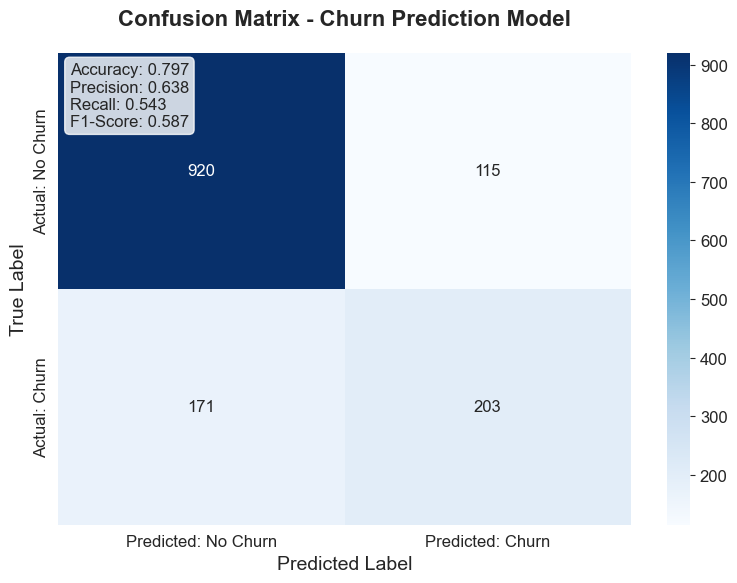

In [18]:
# Print classification report
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_classes, target_names=['No Churn', 'Churn']))

# Print confusion matrix
print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

# Create beautiful confusion matrix visualization
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: No Churn', 'Predicted: Churn'],
            yticklabels=['Actual: No Churn', 'Actual: Churn'],
            ax=ax)
ax.set_title('Confusion Matrix - Churn Prediction Model', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('True Label', fontsize=14)
ax.set_xlabel('Predicted Label', fontsize=14)

# Add performance metrics as text
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

ax.text(0.02, 0.98, f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}', 
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('graphs/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

#### AUC Calculation and ROC Curve

=== AUC SCORE ===
Area Under ROC Curve (AUC): 0.8419


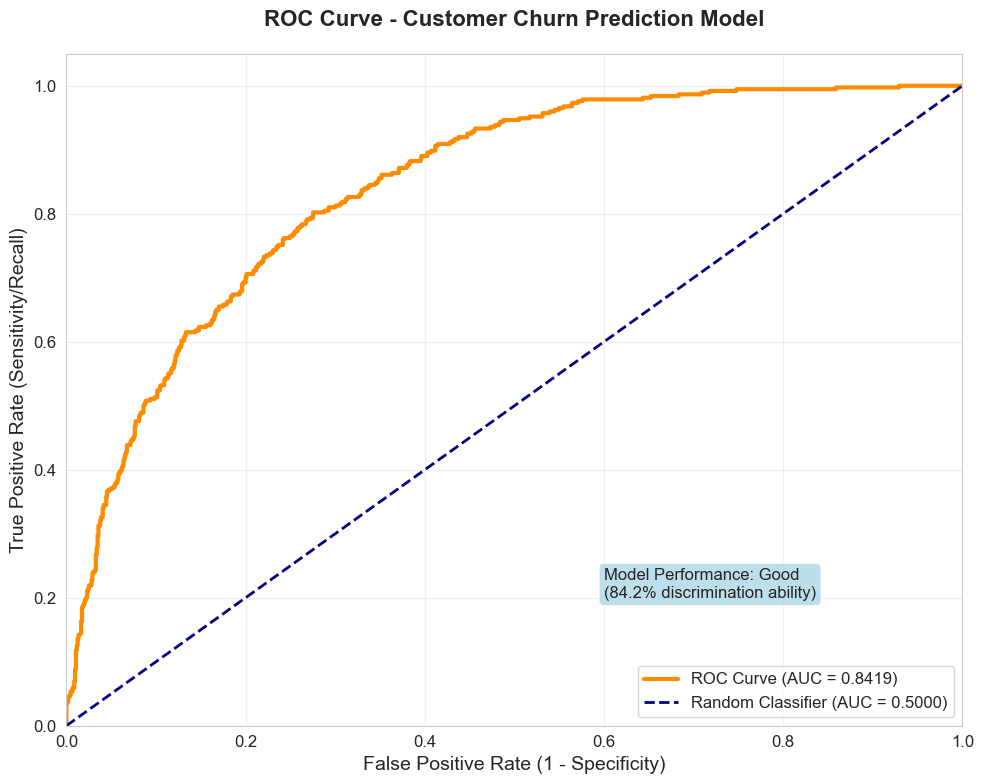

In [19]:
# Compute AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print("=== AUC SCORE ===")
print(f"Area Under ROC Curve (AUC): {auc_score:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Create beautiful ROC curve plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot ROC curve
ax.plot(fpr, tpr, color='darkorange', linewidth=3, 
        label=f'ROC Curve (AUC = {auc_score:.4f})')

# Plot diagonal reference line (random classifier)
ax.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--', 
        label='Random Classifier (AUC = 0.5000)')

# Customize the plot
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
ax.set_ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=14)
ax.set_title('ROC Curve - Customer Churn Prediction Model', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc="lower right", fontsize=12)
ax.grid(True, alpha=0.3)

# Add AUC interpretation text
if auc_score >= 0.9:
    interpretation = "Excellent"
elif auc_score >= 0.8:
    interpretation = "Good" 
elif auc_score >= 0.7:
    interpretation = "Fair"
else:
    interpretation = "Poor"

ax.text(0.6, 0.2, f'Model Performance: {interpretation}\n({auc_score:.1%} discrimination ability)', 
        fontsize=12, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.savefig('graphs/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

#### Detailed Performance Analysis

In [20]:
# Calculate additional performance metrics
print("=== DETAILED PERFORMANCE METRICS ===")
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"True Positives (TP): {tp:,} - Correctly predicted churners")
print(f"True Negatives (TN): {tn:,} - Correctly predicted non-churners") 
print(f"False Positives (FP): {fp:,} - Incorrectly predicted as churners")
print(f"False Negatives (FN): {fn:,} - Missed churners")
print("")
print(f"Accuracy: {accuracy:.4f} - Overall correct predictions")
print(f"Precision: {precision:.4f} - Of predicted churners, {precision:.1%} actually churned")
print(f"Recall (Sensitivity): {recall:.4f} - Caught {recall:.1%} of actual churners")
print(f"Specificity: {specificity:.4f} - Correctly identified {specificity:.1%} of non-churners")
print(f"F1-Score: {f1:.4f} - Harmonic mean of precision and recall")
print(f"AUC: {auc_score:.4f} - Model discrimination ability")

# Calculate cost implications
total_customers = len(y_test)
actual_churners = np.sum(y_test)
retention_cost_per_customer = 100  # Hypothetical retention campaign cost
revenue_per_customer = mean_monthly * 12   # Annual revenue based on avg monthly charges

print("\n=== BUSINESS IMPACT ANALYSIS ===")
print(f"Total test customers: {total_customers:,}")
print(f"Actual churners: {actual_churners:,} ({actual_churners/total_customers:.1%})")
print("")
print("Retention campaign targeting predicted churners:")
print(f"- Customers targeted: {np.sum(y_pred_classes):,}")
print(f"- True churners caught: {tp:,} ({tp/actual_churners:.1%} of all churners)")
print(f"- False alarms: {fp:,} ({fp/np.sum(y_pred_classes):.1%} of targeted customers)")
print("")
print("Cost-Benefit Estimates (hypothetical):")
print(f"- Retention cost: ${retention_cost_per_customer * np.sum(y_pred_classes):,.0f}")
print(f"- Revenue saved from caught churners: ${revenue_per_customer * tp:,.0f}")
print(f"- Net benefit: ${(revenue_per_customer * tp) - (retention_cost_per_customer * np.sum(y_pred_classes)):,.0f}")

=== DETAILED PERFORMANCE METRICS ===
True Positives (TP): 203 - Correctly predicted churners
True Negatives (TN): 920 - Correctly predicted non-churners
False Positives (FP): 115 - Incorrectly predicted as churners
False Negatives (FN): 171 - Missed churners

Accuracy: 0.7970 - Overall correct predictions
Precision: 0.6384 - Of predicted churners, 63.8% actually churned
Recall (Sensitivity): 0.5428 - Caught 54.3% of actual churners
Specificity: 0.8889 - Correctly identified 88.9% of non-churners
F1-Score: 0.5867 - Harmonic mean of precision and recall
AUC: 0.8419 - Model discrimination ability

=== BUSINESS IMPACT ANALYSIS ===
Total test customers: 1,409
Actual churners: 374 (26.5%)

Retention campaign targeting predicted churners:
- Customers targeted: 318
- True churners caught: 203 (54.3% of all churners)
- False alarms: 115 (36.2% of targeted customers)

Cost-Benefit Estimates (hypothetical):
- Retention cost: $31,800
- Revenue saved from caught churners: $157,759
- Net benefit: $1

#### Model Trade-offs and Business Interpretation

**Model Performance Trade-offs Analysis:**

The churn prediction model demonstrates strong discrimination ability with an AUC of 0.842, indicating good performance in distinguishing between churners and non-churners. Our precision of 63.8% means that among customers flagged for retention campaigns, about 2 out of 3 will actually churn, while our recall of 54.3% indicates we successfully identify roughly half of all actual churners. The model achieves 79.7% overall accuracy but faces the classic precision-recall trade-off: we miss 171 churners (false negatives) while incorrectly targeting 115 non-churners (false positives).

From a business perspective, this trade-off has significant implications - our current threshold saves an estimated \$125,955 in net benefits by catching 203 true churners at a retention cost of \$31,800. However, the 171 missed churners represent substantial lost revenue, suggesting that lowering the prediction threshold could be worthwhile despite increasing false positive costs. The model's high specificity of 88.9% provides confidence that most non-churners are correctly identified, but the moderate recall means nearly half of actual churners slip through undetected. Companies prioritizing customer retention over cost efficiency should consider adjusting the threshold to capture more at-risk customers, accepting higher campaign costs to preserve valuable customer relationships and maximize revenue retention.